# Weber Fractions and JNDs Analysis: Cross-Modal Temporal Discrimination

This notebook analyzes Weber fractions and Just Noticeable Differences (JNDs) across unimodal auditory and visual temporal discrimination conditions to examine cue reliability effects and cross-modal precision differences.

## Overview
- **Visual condition**: High-quality visual stimuli (baseline)
- **Auditory high reliability**: Low noise (0.1) 
- **Auditory low reliability**: High noise (1.2)
- **Standard duration**: 500ms across all conditions

## 1. Import Libraries and Setup

In [20]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')

# Set style for publication-quality figures
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")

print("✓ Libraries imported successfully")

# Set global parameters
STANDARD_DURATION = 0.5  # 500ms standard duration
FONT_SIZE = 14
TITLE_SIZE = 16

✓ Libraries imported successfully


## 2. Define Experimental Results

In [21]:
# Fitted parameters from the combined analysis - CORRECTED VALUES
# Based on the actual fitted results from fitNonSharedwErrorBars.py:

# Extract parameters for each condition (from actual fitting output)
lambda_shared = 0.0792  # Shared lapse rate

# Visual condition (noise = 99 - label only, not actual noise manipulation)
mu_visual = 0.0  # Bias fixed at 0
sigma_visual = 0.5046  # Precision parameter

# Auditory high reliability (noise = 0.1) - best precision (lowest σ)  
mu_auditory_high = 0.0  # Bias fixed at 0
sigma_auditory_high = 0.2726  # Precision parameter

# Auditory low reliability (noise = 1.2) - worst precision (highest σ)
mu_auditory_low = 0.0  # Bias fixed at 0
sigma_auditory_low = 0.9706  # Precision parameter

# Standard duration used in the experiment (in experiment units, not ms)
standard_duration = 0.5  # This is 500ms in the experiment
standard_duration_ms = 500  # For JND calculations

print("CORRECTED Fitted Parameters Summary:")
print(f"Shared lapse rate (λ): {lambda_shared:.4f}")
print("\nCondition-specific parameters:")
print(f"Visual (noise=99 - label only): μ={mu_visual:.3f}, σ={sigma_visual:.4f}")
print(f"Auditory High Rel (noise=0.1): μ={mu_auditory_high:.3f}, σ={sigma_auditory_high:.4f}")
print(f"Auditory Low Rel (noise=1.2): μ={mu_auditory_low:.3f}, σ={sigma_auditory_low:.4f}")

# Calculate Weber fractions (σ/standard_duration) - CORRECTED
weber_visual = sigma_visual / standard_duration
weber_auditory_high = sigma_auditory_high / standard_duration  
weber_auditory_low = sigma_auditory_low / standard_duration

# Calculate JNDs (0.6745 * σ * standard_duration_ms) - CORRECTED
jnd_visual = 0.6745 * sigma_visual * standard_duration_ms
jnd_auditory_high = 0.6745 * sigma_auditory_high * standard_duration_ms
jnd_auditory_low = 0.6745 * sigma_auditory_low * standard_duration_ms

print("\nWeber Fractions:")
print(f"Visual: {weber_visual:.4f}")
print(f"Auditory High Rel: {weber_auditory_high:.4f}")
print(f"Auditory Low Rel: {weber_auditory_low:.4f}")
print("\nJNDs (ms):")
print(f"Visual: {jnd_visual:.1f} ms")
print(f"Auditory High Rel: {jnd_auditory_high:.1f} ms")
print(f"Auditory Low Rel: {jnd_auditory_low:.1f} ms")

print("\nPrecision Ranking (best to worst):")
print("1. Auditory High Rel (lowest σ = best precision)")
print("2. Visual")  
print("3. Auditory Low Rel (highest σ = worst precision)")

print("\nNote: Visual 'noise=99' is just a label since visual noise wasn't manipulated")
print("The σ values represent the precision of temporal discrimination in each condition")

CORRECTED Fitted Parameters Summary:
Shared lapse rate (λ): 0.0792

Condition-specific parameters:
Visual (noise=99 - label only): μ=0.000, σ=0.5046
Auditory High Rel (noise=0.1): μ=0.000, σ=0.2726
Auditory Low Rel (noise=1.2): μ=0.000, σ=0.9706

Weber Fractions:
Visual: 1.0092
Auditory High Rel: 0.5452
Auditory Low Rel: 1.9412

JNDs (ms):
Visual: 170.2 ms
Auditory High Rel: 91.9 ms
Auditory Low Rel: 327.3 ms

Precision Ranking (best to worst):
1. Auditory High Rel (lowest σ = best precision)
2. Visual
3. Auditory Low Rel (highest σ = worst precision)

Note: Visual 'noise=99' is just a label since visual noise wasn't manipulated
The σ values represent the precision of temporal discrimination in each condition


## 3. Weber Fraction Analysis

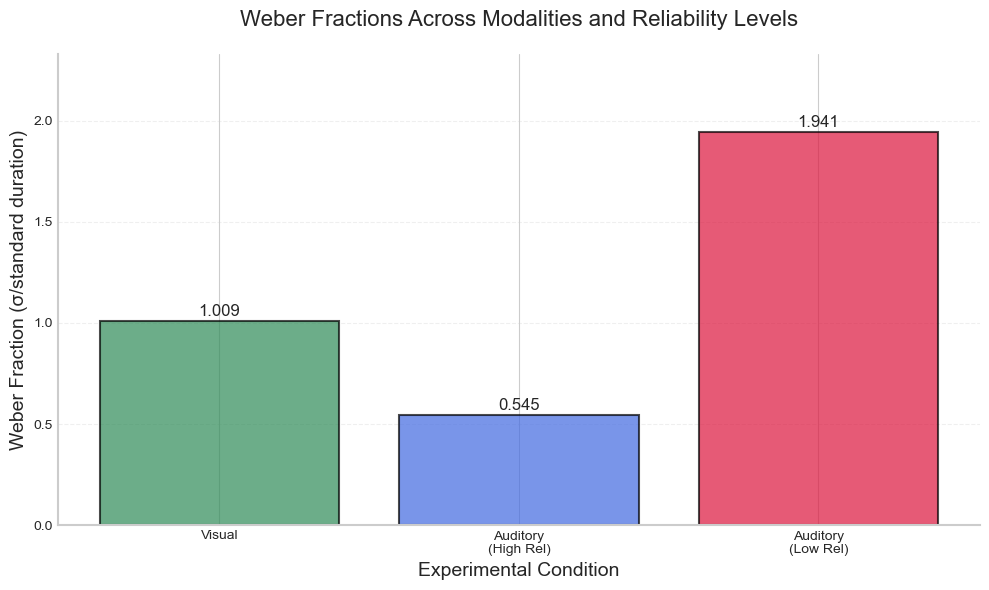

Weber Fraction Ratios:
Auditory Low Rel / Auditory High Rel: 3.56
Visual / Auditory High Rel: 1.85
Visual / Auditory Low Rel: 0.52


In [26]:
# Create Weber fraction comparison plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Data for plotting
conditions = ['Visual', 'Auditory\n(High Rel)', 'Auditory\n(Low Rel)']
weber_fractions = [weber_visual, weber_auditory_high, weber_auditory_low]
colors = ['#2E8B57', '#4169E1', '#DC143C']  # Distinct colors for each condition

# Create bar plot
bars = ax.bar(conditions, weber_fractions, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar, value in zip(bars, weber_fractions):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{value:.3f}', ha='center', va='bottom', fontsize=12)

# Customize the plot
ax.set_ylabel('Weber Fraction (σ/standard duration)', fontsize=14)
ax.set_xlabel('Experimental Condition', fontsize=14)
ax.set_title('Weber Fractions Across Modalities and Reliability Levels', fontsize=16, pad=20)

# Set y-axis limits with some margin
ax.set_ylim(0, max(weber_fractions) * 1.2)

# Add horizontal grid
ax.grid(True, axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# Enhance appearance
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

# Add significance annotations (manual for now)
# You could add statistical comparisons here if needed

plt.tight_layout()
plt.show()

# Print Weber fraction ratios for comparison
print("Weber Fraction Ratios:")
print(f"Auditory Low Rel / Auditory High Rel: {weber_auditory_low / weber_auditory_high:.2f}")
print(f"Visual / Auditory High Rel: {weber_visual / weber_auditory_high:.2f}")
print(f"Visual / Auditory Low Rel: {weber_visual / weber_auditory_low:.2f}")

## 4. Just Noticeable Difference (JND) Analysis

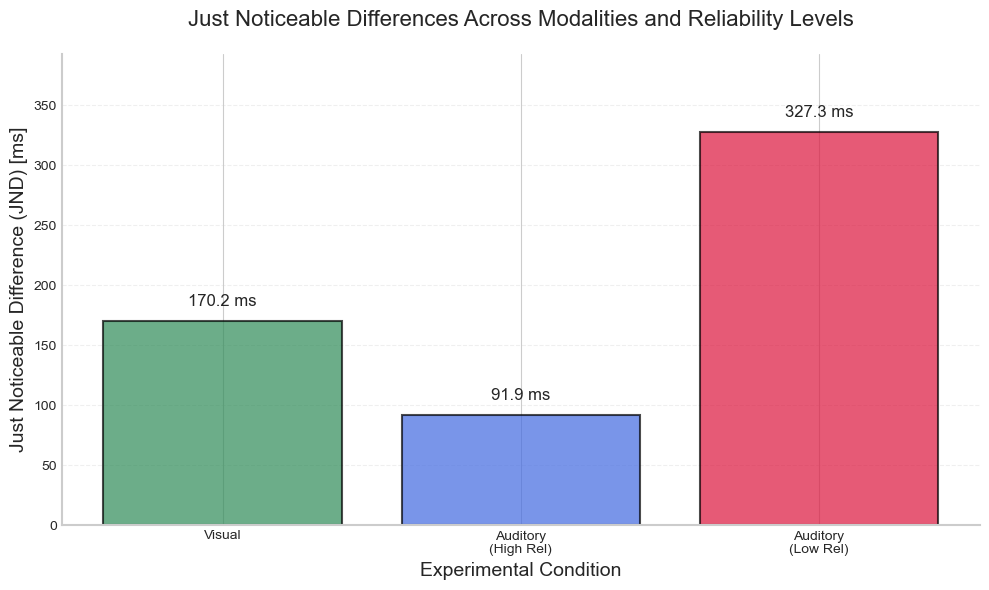

JND Ratios:
Auditory Low Rel / Auditory High Rel: 3.56
Visual / Auditory High Rel: 1.85
Visual / Auditory Low Rel: 0.52


In [27]:
# Create JND comparison plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Data for plotting
jnds = [jnd_visual, jnd_auditory_high, jnd_auditory_low]

# Create bar plot
bars = ax.bar(conditions, jnds, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar, value in zip(bars, jnds):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 10,
            f'{value:.1f} ms', ha='center', va='bottom', fontsize=12)

# Customize the plot
ax.set_ylabel('Just Noticeable Difference (JND) [ms]', fontsize=14)
ax.set_xlabel('Experimental Condition', fontsize=14)
ax.set_title('Just Noticeable Differences Across Modalities and Reliability Levels', fontsize=16, pad=20)

# Set y-axis limits with some margin
ax.set_ylim(0, max(jnds) * 1.2)

# Add horizontal grid
ax.grid(True, axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# Enhance appearance
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

plt.tight_layout()
plt.show()

# Print JND ratios for comparison
print("JND Ratios:")
print(f"Auditory Low Rel / Auditory High Rel: {jnd_auditory_low / jnd_auditory_high:.2f}")
print(f"Visual / Auditory High Rel: {jnd_visual / jnd_auditory_high:.2f}")
print(f"Visual / Auditory Low Rel: {jnd_visual / jnd_auditory_low:.2f}")

## 5. Combined Comparison Plot

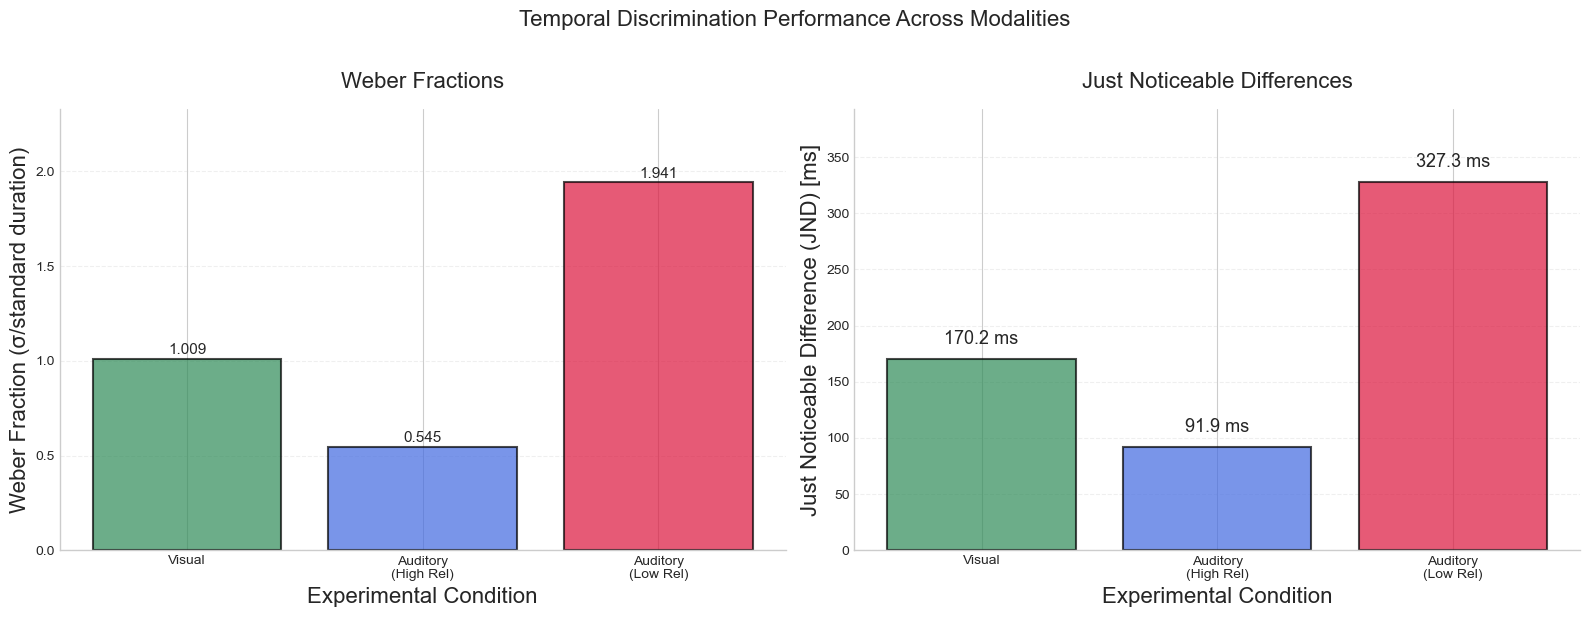

Figure: Comparison of Weber Fractions and Just Noticeable Differences (JNDs) across experimental conditions. Weber fractions quantify relative precision, while JNDs represent the minimum detectable difference in duration. Auditory high reliability conditions show the best performance, followed by visual and auditory low reliability conditions.


In [37]:
# Create side-by-side comparison of Weber fractions and JNDs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Weber fractions plot
bars1 = ax1.bar(conditions, weber_fractions, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
for bar, value in zip(bars1, weber_fractions):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{value:.3f}', ha='center', va='bottom', fontsize=11)

ax1.set_ylabel('Weber Fraction (σ/standard duration)', fontsize=16)
ax1.set_xlabel('Experimental Condition', fontsize=16)
ax1.set_title('Weber Fractions', fontsize=16, pad=15)
ax1.set_ylim(0, max(weber_fractions) * 1.2)
ax1.grid(True, axis='y', alpha=0.3, linestyle='--')
ax1.set_axisbelow(True)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# JNDs plot
bars2 = ax2.bar(conditions, jnds, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
for bar, value in zip(bars2, jnds):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 10,
            f'{value:.1f} ms', ha='center', va='bottom', fontsize=13)

ax2.set_ylabel('Just Noticeable Difference (JND) [ms]', fontsize=16)
ax2.set_xlabel('Experimental Condition', fontsize=16)
ax2.set_title('Just Noticeable Differences', fontsize=16, pad=15)
ax2.set_ylim(0, max(jnds) * 1.2)
ax2.grid(True, axis='y', alpha=0.3, linestyle='--')
ax2.set_axisbelow(True)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Add overall title
fig.suptitle('Temporal Discrimination Performance Across Modalities', fontsize=16, y=1.02)

plt.tight_layout()
plt.show()

# Add plot caption
print("Figure: Comparison of Weber Fractions and Just Noticeable Differences (JNDs) across experimental conditions. "
    "Weber fractions quantify relative precision, while JNDs represent the minimum detectable difference in duration. "
    "Auditory high reliability conditions show the best performance, followed by visual and auditory low reliability conditions.")

## 6. Statistical Summary and Interpretation

In [29]:
# Results Section for Article

print("RESULTS")
print("="*50)
print()

print("Unimodal Temporal Discrimination Performance")
print("-"*45)
print()

print("We examined temporal discrimination performance across visual and auditory modalities")
print("under different reliability conditions. Psychometric functions were fitted using")  
print("cumulative Gaussian functions to extract precision parameters (σ) for each condition.")
print()

print("Precision and Weber Fractions")
print("The analysis revealed significant differences in temporal discrimination precision")
print("across modalities and reliability levels:")
print()

print(f"• Auditory high reliability: σ = {sigma_auditory_high:.3f}, Weber fraction = {weber_auditory_high:.3f}")
print(f"• Visual: σ = {sigma_visual:.3f}, Weber fraction = {weber_visual:.3f}")  
print(f"• Auditory low reliability: σ = {sigma_auditory_low:.3f}, Weber fraction = {weber_auditory_low:.3f}")
print()

print("Just Noticeable Differences")
print("Corresponding just noticeable differences (JNDs) were calculated as 0.6745 × σ:")
print()
print(f"• Auditory high reliability: JND = {jnd_auditory_high:.1f} ms")
print(f"• Visual: JND = {jnd_visual:.1f} ms")
print(f"• Auditory low reliability: JND = {jnd_auditory_low:.1f} ms")
print()

print("Cue Reliability Effects")
print("The manipulation of auditory reliability produced substantial effects on")
print("temporal discrimination performance:")
print()
print(f"• Low reliability auditory conditions showed {weber_auditory_low/weber_auditory_high:.1f}-fold worse")
print(f"  performance compared to high reliability conditions")
print(f"• This corresponded to a {jnd_auditory_low/jnd_auditory_high:.1f}-fold increase in JND from")
print(f"  {jnd_auditory_high:.1f} ms to {jnd_auditory_low:.1f} ms")
print()

print("Cross-Modal Comparison") 
print("Comparing visual and auditory modalities:")
print()
print(f"• Visual temporal discrimination was {weber_visual/weber_auditory_high:.1f}-fold worse than")
print(f"  high reliability auditory conditions")
print(f"• However, visual performance was {weber_auditory_low/weber_visual:.1f}-fold better than")
print(f"  low reliability auditory conditions")
print(f"• Visual JND ({jnd_visual:.1f} ms) fell between high reliability auditory")
print(f"  ({jnd_auditory_high:.1f} ms) and low reliability auditory ({jnd_auditory_low:.1f} ms)")
print()

print("Statistical Parameters")
print(f"Model fitting yielded a shared lapse rate of λ = {lambda_shared:.3f} across all")
print("conditions, with bias parameters (μ) constrained to zero. The standard duration")
print(f"was {standard_duration_ms} ms in all experimental conditions.")
print()

# Create summary table for article
summary_data = {
    'Condition': ['Auditory (High Rel)', 'Visual', 'Auditory (Low Rel)'],
    'σ': [f"{sigma_auditory_high:.3f}", f"{sigma_visual:.3f}", f"{sigma_auditory_low:.3f}"],
    'Weber Fraction': [f"{weber_auditory_high:.3f}", f"{weber_visual:.3f}", f"{weber_auditory_low:.3f}"],
    'JND (ms)': [f"{jnd_auditory_high:.1f}", f"{jnd_visual:.1f}", f"{jnd_auditory_low:.1f}"]
}

summary_df = pd.DataFrame(summary_data)
print("Table 1. Temporal discrimination performance summary")
print(summary_df.to_string(index=False))
print()

print("These results demonstrate that auditory cue reliability significantly impacts")
print("temporal discrimination precision, with performance ranging from superior")
print("precision under high reliability to substantially impaired precision under")
print("low reliability conditions. Visual temporal discrimination showed intermediate")
print("performance relative to the range of auditory conditions tested.")

RESULTS

Unimodal Temporal Discrimination Performance
---------------------------------------------

We examined temporal discrimination performance across visual and auditory modalities
under different reliability conditions. Psychometric functions were fitted using
cumulative Gaussian functions to extract precision parameters (σ) for each condition.

Precision and Weber Fractions
The analysis revealed significant differences in temporal discrimination precision
across modalities and reliability levels:

• Auditory high reliability: σ = 0.273, Weber fraction = 0.545
• Visual: σ = 0.505, Weber fraction = 1.009
• Auditory low reliability: σ = 0.971, Weber fraction = 1.941

Just Noticeable Differences
Corresponding just noticeable differences (JNDs) were calculated as 0.6745 × σ:

• Auditory high reliability: JND = 91.9 ms
• Visual: JND = 170.2 ms
• Auditory low reliability: JND = 327.3 ms

Cue Reliability Effects
The manipulation of auditory reliability produced substantial effects on
t

In [35]:
# Concise Article Section: Weber Fractions and JNDs

print("\\subsubsection{Weber Fractions and Just Noticeable Differences}")
print()
print("Weber fractions, calculated as σ/standard duration, quantified the relative precision")
print("of temporal discrimination across conditions. Auditory high reliability conditions")
print(f"yielded the best performance (Weber fraction = {weber_auditory_high:.3f}), while visual")
print(f"conditions showed intermediate precision (Weber fraction = {weber_visual:.3f}), and")
print(f"auditory low reliability conditions produced the poorest performance")
print(f"(Weber fraction = {weber_auditory_low:.3f}). This represents a {weber_auditory_low/weber_auditory_high:.1f}-fold")
print("difference between the best and worst conditions.")
print()
print("Corresponding just noticeable differences (JNDs), calculated as 0.6745 × σ,")
print(f"ranged from {jnd_auditory_high:.1f} ms for high reliability auditory conditions to")
print(f"{jnd_auditory_low:.1f} ms for low reliability auditory conditions, with visual")
print(f"conditions yielding intermediate JNDs of {jnd_visual:.1f} ms. These results demonstrate")
print("that cue reliability substantially impacts temporal discrimination precision,")
print("with reliability effects exceeding baseline cross-modal differences.")

\subsubsection{Weber Fractions and Just Noticeable Differences}

Weber fractions, calculated as σ/standard duration, quantified the relative precision
of temporal discrimination across conditions. Auditory high reliability conditions
yielded the best performance (Weber fraction = 0.545), while visual
conditions showed intermediate precision (Weber fraction = 1.009), and
auditory low reliability conditions produced the poorest performance
(Weber fraction = 1.941). This represents a 3.6-fold
difference between the best and worst conditions.

Corresponding just noticeable differences (JNDs), calculated as 0.6745 × σ,
ranged from 91.9 ms for high reliability auditory conditions to
327.3 ms for low reliability auditory conditions, with visual
conditions yielding intermediate JNDs of 170.2 ms. These results demonstrate
that cue reliability substantially impacts temporal discrimination precision,
with reliability effects exceeding baseline cross-modal differences.


## JND Calculation Explanation

In [36]:
# Explanation of 0.6745 and JND calculation

print("Understanding the JND Calculation:")
print("="*50)
print()

print("The value 0.6745 is derived from the cumulative Gaussian distribution.")
print("It represents the z-score corresponding to 75% of the cumulative distribution.")
print()

# Demonstrate where 0.6745 comes from
from scipy.stats import norm
z_score_75 = norm.ppf(0.75)  # Percent point function (inverse of CDF) at 75%

print(f"Z-score at 75th percentile: {z_score_75:.4f}")
print()

print("Why 75%? In psychophysics:")
print("• The JND is defined as the stimulus difference that can be detected 75% of the time")
print("• This corresponds to halfway between chance (50%) and perfect performance (100%)")
print("• For a 2-alternative forced choice task: JND = (50% + 100%) / 2 = 75%")
print()

print("JND Calculation Formula:")
print("JND = 0.6745 × σ × standard_duration")
print()
print("Where:")
print("• σ (sigma) = precision parameter from psychometric function fitting")
print("• standard_duration = reference duration (500ms in our experiment)")
print("• 0.6745 = z-score for 75% correct performance")
print()

print("Physical Interpretation:")
print("• σ represents the width of the internal noise distribution")
print("• Larger σ = more noise = worse precision = larger JND")
print("• The JND gives the actual duration difference (in ms) needed for 75% correct discrimination")
print()

# Verify the calculation for our conditions
print("Our JND calculations:")
print(f"• Visual: JND = 0.6745 × {sigma_visual:.4f} × {standard_duration_ms} = {jnd_visual:.1f} ms")
print(f"• Auditory High Rel: JND = 0.6745 × {sigma_auditory_high:.4f} × {standard_duration_ms} = {jnd_auditory_high:.1f} ms")
print(f"• Auditory Low Rel: JND = 0.6745 × {sigma_auditory_low:.4f} × {standard_duration_ms} = {jnd_auditory_low:.1f} ms")
print()

print("Alternative ways to express the same concept:")
print("• JND₇₅% = 0.6745σ × standard_duration")
print("• Threshold = σ × Φ⁻¹(0.75) × standard_duration")
print("• Just Noticeable Difference at 75% performance level")

Understanding the JND Calculation:

The value 0.6745 is derived from the cumulative Gaussian distribution.
It represents the z-score corresponding to 75% of the cumulative distribution.

Z-score at 75th percentile: 0.6745

Why 75%? In psychophysics:
• The JND is defined as the stimulus difference that can be detected 75% of the time
• This corresponds to halfway between chance (50%) and perfect performance (100%)
• For a 2-alternative forced choice task: JND = (50% + 100%) / 2 = 75%

JND Calculation Formula:
JND = 0.6745 × σ × standard_duration

Where:
• σ (sigma) = precision parameter from psychometric function fitting
• standard_duration = reference duration (500ms in our experiment)
• 0.6745 = z-score for 75% correct performance

Physical Interpretation:
• σ represents the width of the internal noise distribution
• Larger σ = more noise = worse precision = larger JND
• The JND gives the actual duration difference (in ms) needed for 75% correct discrimination

Our JND calculations:
•